Imports


In [ ]:
!pip install antropy

import torch

import mne

import antropy


from sklearn.preprocessing import label_binarize

mne.set_log_level('ERROR')

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
import pandas as pd

import numpy as np
from scipy.fftpack import fft, ifft
from scipy.stats import entropy
from sklearn.preprocessing import LabelEncoder
from scipy.stats import skew
from scipy.stats import kurtosis
#NOTE USE LABEL ENCODER BEFORE RUNNING THE FULL VERSION 

Dataset and preprocessing


In [3]:
#this is where we actually extract the features 
def get_variability_measures(eeg_data):
    variability_features=[]
    std_value=np.std(eeg_data,axis=1)
    iqr_value = np.subtract(*np.percentile(eeg_data, [75, 25], axis=1))  # IQR of all channels
    variability_features.extend((np.mean(std_value),np.mean(iqr_value)))
    return variability_features

def get_distribution_features(eeg_data):
    distribution_features=[]
    skewness_value = skew(eeg_data, axis=1)
    kurtosis_value = kurtosis(eeg_data, axis=1) 
    distribution_features.extend((np.mean(skewness_value),np.mean(kurtosis_value)))
    return distribution_features
  
def zero_crossings(signal):
    # If signal crosses zero line, we'll have a change in sign of adjacent values
    return ((signal[:-1] * signal[1:]) < 0).sum()

def frequency_content_features(eeg_data):
    # Calculate zero crossings for each channel
    zero_crossings_values = np.apply_along_axis(zero_crossings, 1, eeg_data)
    
    mean_zero_crossings = np.mean(zero_crossings_values)
    return mean_zero_crossings

def hjorth_mobility(signal):
    first_derivative = np.diff(signal)
    variance = np.var(signal)
    variance_derivative = np.var(first_derivative)
    mobility = np.sqrt(variance_derivative / variance)
    return mobility

def get_hjorth_parameters(eeg_data):
    hjorth_parameters=[]
    signal=eeg_data
    
    
    
    #hjorth complexity
    first_derivative = np.diff(signal)
    second_derivative = np.diff(first_derivative)
    mobility = hjorth_mobility(signal)
    mobility_derivative = hjorth_mobility(first_derivative)
    complexity = mobility_derivative / mobility
    hjorth_parameters.extend((mobility,complexity))
    return hjorth_parameters

def get_higuchi_fractal_dimension(eeg_data):
    signal=eeg_data
    kmax=6
    Lk = []
    for k in range(1, kmax):
        Lm = []
        for m in range(0, k):
            Lmk = 0
            for i in range(1, int(np.floor((len(signal) - m) / k))):
                Lmk += abs(signal[m + i * k] - signal[m + i * k - k])
            Lmk = Lmk * (len(signal) / (k * int(np.floor((len(signal) - m) / k))))
            Lm.append(Lmk)
        Lk.append(np.log(np.mean(Lm)))
    (slope, _) = np.polyfit(np.log(range(1, kmax)), Lk, 1)
    return -slope

def get_entropies(eeg_data):
    entropies=[]
    signal=eeg_data
    #shanon entropy
    hist, _ = np.histogram(signal, bins=64, density=True)
    shannon_entropy=entropy(hist)
    #spectral entropy
    spectral_entropy=antropy.spectral_entropy(eeg_data,200,'welch',nperseg=None,normalize=True)
    #binned_entorpy
    hist, _ = np.histogram(signal, bins=10)
    binned_entropy=entropy(hist)
    entropies.extend((shannon_entropy,spectral_entropy,binned_entropy))
    return entropies
    
def get_power_bands(new_raw,tmin,tmax):
    
    power_features=[]
    

# Define frequency bands
    bands = {
        'delta': (0.5, 4),
        'theta': (4, 8),
        'alpha': (8, 13),
        'beta': (13, 30),
        'gamma': (30, None)  # Assuming Gamma is 30+ Hz
    }

# Dictionary to hold power values for each band
    band_power = {}

    for band, (l_freq, h_freq) in bands.items():
        # Filter the data for each frequency band
        band_data = new_raw.copy().filter(l_freq=l_freq, h_freq=h_freq, picks='eeg', verbose=False)

        # Compute the PSD for the filtered data using the Welch method
        sfreq = raw.info['sfreq'] 
        fmax = min(h_freq if h_freq is not None else sfreq / 2, sfreq / 2)
        spectrum = band_data.compute_psd(method='welch', fmin=l_freq, fmax=fmax,picks='eeg',verbose=False)

        psd=spectrum.get_data()
        # Integrate the PSD over the frequencies of interest to get the absolute power for each band
        band_power[band] = psd.mean(axis=1).sum()



    
    power_features.extend(band_power.values())
    
    epsilon = 1e-6

    # Calculate power ratios using values from the dictionary
    delta_theta_ratio = band_power['delta'] / (band_power['theta'] + epsilon)
    delta_alpha_ratio = band_power['delta'] / (band_power['alpha'] + epsilon)
    theta_beta_ratio = band_power['theta'] / (band_power['beta'] + epsilon)
    alpha_gamma_ratio = band_power['alpha'] / (band_power['gamma'] + epsilon)
    beta_gamma_ratio = band_power['beta'] / (band_power['gamma'] + epsilon)

    # Append the calculated ratios 
    power_features.extend([delta_theta_ratio, delta_alpha_ratio, theta_beta_ratio, alpha_gamma_ratio, beta_gamma_ratio])

    # Calculate power sums using values from the dictionary
    delta_theta_sum = band_power['delta'] + band_power['theta']
    alpha_beta_sum = band_power['alpha'] + band_power['beta']
    theta_gamma_sum = band_power['theta'] + band_power['gamma']

    # Append the calculated sums 
    power_features.extend([delta_theta_sum, alpha_beta_sum, theta_gamma_sum])
    total_power=band_power['delta'] + band_power['theta']+ band_power['gamma']+band_power['alpha']
    power_features.append(total_power)
    return power_features
    

    

    

In [5]:

    
def extract_features(segment, segment_info,tmin,tmax):
    features = []
    eeg_data = np.real(segment.get_data())
    new_raw = mne.io.RawArray(eeg_data, segment_info)
    
    
    features.extend(get_variability_measures(eeg_data))
    features.extend(get_distribution_features(eeg_data))
    
    
    zero_crossing_feature = [frequency_content_features(eeg_data)]
    features.extend(zero_crossing_feature)
    
    # Extend with placeholders for missing features (Hjorth Mobility, etc.)
    features.extend(get_hjorth_parameters(eeg_data)) 
    
    higuchi_fractal_dimension=[get_higuchi_fractal_dimension(eeg_data)]
    features.extend(higuchi_fractal_dimension)
    
    features.extend(get_entropies(eeg_data))
    power_band_features = get_power_bands(new_raw,tmin,tmax)
    features.extend(power_band_features)
    
    
    
    
    return features


def create_raw_from_parquet(parquet_file):
    df=pd.read_parquet(parquet_file)
    data=df.to_numpy().T
    info=mne.create_info(ch_names=list(df.columns),sfreq=200,ch_types='eeg')
    raw=mne.io.RawArray(data,info)
    return raw

def get_duration(raw):
    num_samples=len(raw.times)
    sampling_freq=raw.info['sfreq']
    duration=np.floor(num_samples/sampling_freq)
    
    return duration

In [ ]:



# Initialize an empty DataFrame for the new training data
columns = [
    'eeg_id', 
    'eeg_sub_id', 
    'patient_id', 
    'Standard Deviation (STD)', 
    'Inter-Quartile Range (IQR)', 
    'Skewness', 
    'Kurtosis', 
    'Number of Zero Crossings', 
    'Hjorth Mobility', 
    'Hjorth Complexity', 
    'Higuchi Fractal Dimension', 
    'Shannon Entropy', 
    'Spectral Entropy', 
    'Binned Entropy', 
    'Delta Power', 
    'Theta Power', 
    'Alpha Power', 
    'Beta Power', 
    'Gamma Power', 
    'Delta/Theta Ratio', 
    'Delta/Alpha Ratio', 
    'Theta/Beta Ratio', 
    'Alpha/Gamma Ratio', 
    'Beta/Gamma Ratio', 
    'Delta+Theta Power', 
    'Alpha+Beta Power', 
    'Theta+Gamma Power', 
    'Total Power',
    'expert_consensus'
]

new_train_df = pd.DataFrame(columns=columns)
#print(new_train_df.shape[1])
problematic_files = []
# Load the original training CSV
train_csv = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/train.csv')
count=0
# Loop through each row in the train CSV
for index, row in train_csv.iterrows():
    try:
        eeg_id = row['eeg_id']
        sub_id = row['eeg_sub_id']
        patient_id = row['patient_id']
        seizure_label = row['expert_consensus']

       

        # Load the corresponding parquet file as an mne Raw object
        raw = create_raw_from_parquet(f'/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/{eeg_id}.parquet')
        

        sub_id_start_time=sub_id
        tmin = sub_id_start_time * 50
        tmax = tmin + 50  # This ensures a 50-second window

        # Adjust tmax to not exceed the recording
        tmax = min(tmax, raw.times[-1])

        # Additionally, ensure tmin does not exceed the adjusted tmax or the recording
        tmin = min(tmin, tmax - 0.001)
        segment = raw.copy().crop(tmin, tmax)  # Adjust 'tmin' and 'tmax' as necessary
        segment_info=raw.info


        # Extract features from the surrogate segment
        features = extract_features(segment,segment_info,tmin,tmax)
        #print(len(features))
        # Append to the new DataFrame
        new_row = [eeg_id, sub_id, patient_id] + features + [seizure_label]
        #print(len(new_row))
        new_train_df.loc[len(new_train_df)] = new_row
        count+=1
        print(count)
    except :
            with open("error_log.txt", "a") as file:
            file.write(f"An error occurred: {e}\n")
        continue
    
# Save the new DataFrame to CSV
new_train_df.to_csv('feature_extracted_data.csv', index=False)


1
2


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

3
4


/tmp/ipykernel_34/3956148763.py:98: RuntimeWarning: filter_length (1321) is longer than the signal (400), distortion is likely. Reduce filter length or filter a longer signal.
  band_data = new_raw.copy().filter(l_freq=l_freq, h_freq=h_freq, picks='eeg', verbose=False)


5
6


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

7
8


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

9
10
11
12
13
14


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

15
16


/tmp/ipykernel_34/3956148763.py:98: RuntimeWarning: filter_length (1321) is longer than the signal (400), distortion is likely. Reduce filter length or filter a longer signal.
  band_data = new_raw.copy().filter(l_freq=l_freq, h_freq=h_freq, picks='eeg', verbose=False)


17
18


/tmp/ipykernel_34/3956148763.py:98: RuntimeWarning: filter_length (1321) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  band_data = new_raw.copy().filter(l_freq=l_freq, h_freq=h_freq, picks='eeg', verbose=False)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, w

19
20
21


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

22
23


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

24
25


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

26
27


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

28
29


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

30
31
32
33
34
35


/tmp/ipykernel_34/3956148763.py:98: RuntimeWarning: filter_length (1321) is longer than the signal (400), distortion is likely. Reduce filter length or filter a longer signal.
  band_data = new_raw.copy().filter(l_freq=l_freq, h_freq=h_freq, picks='eeg', verbose=False)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, w

36


/tmp/ipykernel_34/3956148763.py:98: RuntimeWarning: filter_length (1321) is longer than the signal (1), distortion is likely. Reduce filter length or filter a longer signal.
  band_data = new_raw.copy().filter(l_freq=l_freq, h_freq=h_freq, picks='eeg', verbose=False)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, win

37
38


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

39
40


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

41
42
43


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

44
45


/tmp/ipykernel_34/3956148763.py:98: RuntimeWarning: filter_length (1321) is longer than the signal (1200), distortion is likely. Reduce filter length or filter a longer signal.
  band_data = new_raw.copy().filter(l_freq=l_freq, h_freq=h_freq, picks='eeg', verbose=False)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, 

46
47
48
49


/tmp/ipykernel_34/3956148763.py:98: RuntimeWarning: filter_length (1321) is longer than the signal (400), distortion is likely. Reduce filter length or filter a longer signal.
  band_data = new_raw.copy().filter(l_freq=l_freq, h_freq=h_freq, picks='eeg', verbose=False)


50
51


/tmp/ipykernel_34/3956148763.py:98: RuntimeWarning: filter_length (1321) is longer than the signal (1200), distortion is likely. Reduce filter length or filter a longer signal.
  band_data = new_raw.copy().filter(l_freq=l_freq, h_freq=h_freq, picks='eeg', verbose=False)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, 

52
53
54


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

55
56


/tmp/ipykernel_34/3956148763.py:98: RuntimeWarning: filter_length (1321) is longer than the signal (1200), distortion is likely. Reduce filter length or filter a longer signal.
  band_data = new_raw.copy().filter(l_freq=l_freq, h_freq=h_freq, picks='eeg', verbose=False)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, 

57
58
59
60


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

61
62


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

63
64


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

65
66


/tmp/ipykernel_34/3956148763.py:98: RuntimeWarning: filter_length (1321) is longer than the signal (1200), distortion is likely. Reduce filter length or filter a longer signal.
  band_data = new_raw.copy().filter(l_freq=l_freq, h_freq=h_freq, picks='eeg', verbose=False)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, 

67
68
69
70


/tmp/ipykernel_34/3956148763.py:98: RuntimeWarning: filter_length (1321) is longer than the signal (1200), distortion is likely. Reduce filter length or filter a longer signal.
  band_data = new_raw.copy().filter(l_freq=l_freq, h_freq=h_freq, picks='eeg', verbose=False)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, 

71


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

72
73


/tmp/ipykernel_34/3956148763.py:98: RuntimeWarning: filter_length (1321) is longer than the signal (1200), distortion is likely. Reduce filter length or filter a longer signal.
  band_data = new_raw.copy().filter(l_freq=l_freq, h_freq=h_freq, picks='eeg', verbose=False)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, 

74
75


/tmp/ipykernel_34/3956148763.py:98: RuntimeWarning: filter_length (1321) is longer than the signal (400), distortion is likely. Reduce filter length or filter a longer signal.
  band_data = new_raw.copy().filter(l_freq=l_freq, h_freq=h_freq, picks='eeg', verbose=False)


76
77


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

78
79
80


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

81
82
83


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

84
85


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

86
87


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

88
89
90
91


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

92
93


/tmp/ipykernel_34/3956148763.py:98: RuntimeWarning: filter_length (1321) is longer than the signal (400), distortion is likely. Reduce filter length or filter a longer signal.
  band_data = new_raw.copy().filter(l_freq=l_freq, h_freq=h_freq, picks='eeg', verbose=False)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, w

94
95
96


/tmp/ipykernel_34/3956148763.py:98: RuntimeWarning: filter_length (1321) is longer than the signal (1200), distortion is likely. Reduce filter length or filter a longer signal.
  band_data = new_raw.copy().filter(l_freq=l_freq, h_freq=h_freq, picks='eeg', verbose=False)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, 

97
98
99
100


/tmp/ipykernel_34/3956148763.py:98: RuntimeWarning: filter_length (1321) is longer than the signal (400), distortion is likely. Reduce filter length or filter a longer signal.
  band_data = new_raw.copy().filter(l_freq=l_freq, h_freq=h_freq, picks='eeg', verbose=False)


101
102
103


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

104
105


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

106
107
108
109


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

110


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encoun

111
112
113


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

114
115


/tmp/ipykernel_34/3956148763.py:98: RuntimeWarning: filter_length (1321) is longer than the signal (400), distortion is likely. Reduce filter length or filter a longer signal.
  band_data = new_raw.copy().filter(l_freq=l_freq, h_freq=h_freq, picks='eeg', verbose=False)


116
117
118
119


/tmp/ipykernel_34/3956148763.py:98: RuntimeWarning: filter_length (1321) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  band_data = new_raw.copy().filter(l_freq=l_freq, h_freq=h_freq, picks='eeg', verbose=False)


120
121
122
123
124
125


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

126
127


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

128
129


/tmp/ipykernel_34/3956148763.py:98: RuntimeWarning: filter_length (1321) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  band_data = new_raw.copy().filter(l_freq=l_freq, h_freq=h_freq, picks='eeg', verbose=False)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, w

130


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

131
132


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

133
134
135
136


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

137
138


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

139
140
141
142
143
144
145


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

146
147
148


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

149
150
151


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

152
153
154
155
156
157
158
159
160


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

161
162
163
164
165
166
167
168
169
170
171
172
173
174


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

194
195


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

196
197


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

198
199


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

200
201
202


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

203
204


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

205
206


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

207
208


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

209
210


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

211
212
213


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

214
215


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

216
217
218
219
220


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

221
222


/tmp/ipykernel_34/3956148763.py:98: RuntimeWarning: filter_length (1321) is longer than the signal (1200), distortion is likely. Reduce filter length or filter a longer signal.
  band_data = new_raw.copy().filter(l_freq=l_freq, h_freq=h_freq, picks='eeg', verbose=False)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, 

223
224
225
226
227


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

228
229
230
231
232


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

233
234


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

235
236


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

237
238


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

239
240
241
242
243
244
245


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

246
247


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

248
249


/tmp/ipykernel_34/3956148763.py:98: RuntimeWarning: filter_length (1321) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  band_data = new_raw.copy().filter(l_freq=l_freq, h_freq=h_freq, picks='eeg', verbose=False)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, w

250
251


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

252
253
254
255


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

256
257


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

258
259


/tmp/ipykernel_34/3956148763.py:98: RuntimeWarning: filter_length (1321) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  band_data = new_raw.copy().filter(l_freq=l_freq, h_freq=h_freq, picks='eeg', verbose=False)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, w

260
261


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

262
263
264


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

265
266
267


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

268
269


/tmp/ipykernel_34/3956148763.py:98: RuntimeWarning: filter_length (1321) is longer than the signal (1200), distortion is likely. Reduce filter length or filter a longer signal.
  band_data = new_raw.copy().filter(l_freq=l_freq, h_freq=h_freq, picks='eeg', verbose=False)


270
271


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

272
273
274
275
276


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

277
278
279
280
281
282
283


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

284
285


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

286
287
288
289


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

290
291


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

292
293
294
295


/tmp/ipykernel_34/3956148763.py:98: RuntimeWarning: filter_length (1321) is longer than the signal (400), distortion is likely. Reduce filter length or filter a longer signal.
  band_data = new_raw.copy().filter(l_freq=l_freq, h_freq=h_freq, picks='eeg', verbose=False)


296
297
298
299


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

300
301


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

302
303


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

304
305


/tmp/ipykernel_34/3956148763.py:98: RuntimeWarning: filter_length (1321) is longer than the signal (400), distortion is likely. Reduce filter length or filter a longer signal.
  band_data = new_raw.copy().filter(l_freq=l_freq, h_freq=h_freq, picks='eeg', verbose=False)


306
307
308


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

309
310


/tmp/ipykernel_34/3956148763.py:98: RuntimeWarning: filter_length (1321) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  band_data = new_raw.copy().filter(l_freq=l_freq, h_freq=h_freq, picks='eeg', verbose=False)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, w

311
312


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

313
314
315


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

316
317


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

318
319
320
321
322
323
324
325
326
327
328
329
330
331


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

332
333


/tmp/ipykernel_34/3956148763.py:98: RuntimeWarning: filter_length (1321) is longer than the signal (400), distortion is likely. Reduce filter length or filter a longer signal.
  band_data = new_raw.copy().filter(l_freq=l_freq, h_freq=h_freq, picks='eeg', verbose=False)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, w

334


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)
/opt/conda/lib/python3.10/site-packages/antropy/entropy.py:256: RuntimeWarn

In [25]:
segment

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,20 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,200.00 Hz
Highpass,0.00 Hz
Lowpass,100.00 Hz


In [7]:
    raw = create_raw_from_parquet(f'/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/{eeg_id}.parquet')


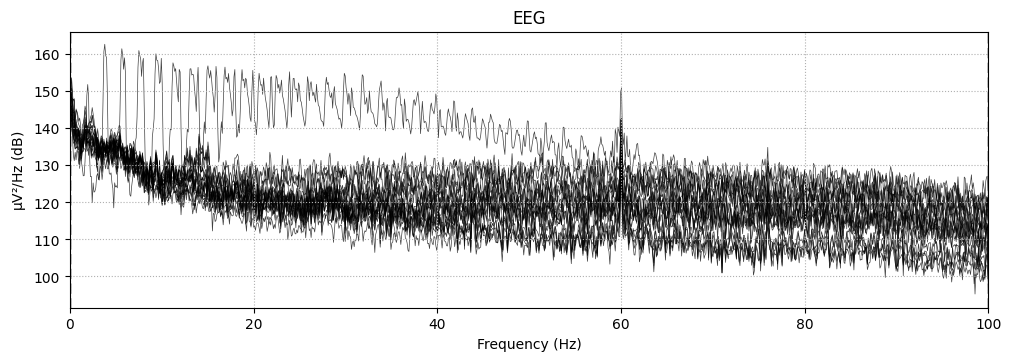

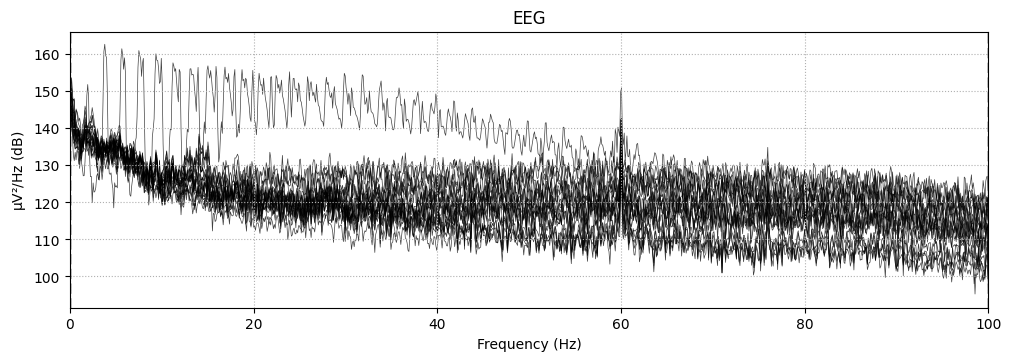

In [11]:
cp raw.compute_psd(picks = 'eeg')

In [71]:
print(new_train_df)

       eeg_id  eeg_sub_id  patient_id  Standard Deviation (STD)  \
0  1628180742           0       42516                 30.275588   

   Inter-Quartile Range (IQR)  Skewness  Kurtosis  Number of Zero Crossings  \
0                   40.444734  0.051111 -0.078174                    291.65   

   Hjorth Mobility  Hjorth Complexity  ...  Delta/Theta Ratio  \
0         0.223952           4.905116  ...           0.691598   

   Delta/Alpha Ratio Theta/Beta Ratio  Alpha/Gamma Ratio  Beta/Gamma Ratio  \
0           0.729855         0.540029           1.112028          2.173113   

   Delta+Theta Power  Alpha+Beta Power  Theta+Gamma Power  Total Power  \
0         116.075163        192.086658         127.089996   239.568331   

   expert_consensus  
0           Seizure  

[1 rows x 29 columns]


In [72]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/train.csv')

# Calculate the percentage of each label
label_percentage = df['expert_consensus'].value_counts(normalize=True) * 100

print(label_percentage)


expert_consensus
Seizure    19.600187
GRDA       17.660112
Other      17.610487
GPD        15.638577
LRDA       15.580524
LPD        13.910112
Name: proportion, dtype: float64


Model Architure
